# DNBLab Jupyter Notebook Tutorial

# MARC-Daten-Analyse 

In diesem Tutorial wird eine XML-Datei `dataset_tutorial_eco.xml`mit MARC-Daten analysiert. Die relevante Informationen werden aus den Datensätzen extrahiert und die Ergebnisse in einer CSV-Datei gespeichert. 
Untersucht werden exemplarisch Hochschulschriften zum Thema "Reform" in der Sachgruppe "330 Wirtschaft". Dafür wird ein speziell erstelltes Datenset verwendet, das sich auf bibliografische Einträge von freien Online-Hochschulschriften aus der DNB konzentriert und nur Veröffentlichungen umfasst, die zwischen 2000 und 2010 erschienen sind.

## Inhalt 

1. [Bibliotheken importieren und Arbeitsumgebung einrichten](#section1)   
2. [XML-Datei direkt als XML mit Hilfe von ElementTree laden](#section2)  
3. [Direkter Zugriff auf die Inhalte des XML](#section3)  
4. [Funktion zur Extraktion mehrerer Inhalte aus den einzelnen Datensätzen](#section4)  
5. [Speichern des Dataframes](#section5)
6. [Analysen und Visualisierungen](#section6)  
    6.1. [Balkendiagramm der häufigsten Autor\*innen](#section6.1)  
    6.2. [Darstellung der Publikationsjahre](#section6.2)  
    6.3. [Darstellung der Publikationsjahre als Kreisdiagramm](#section6.3)



<a id="section1"></a>
## 1. Bibliotheken importieren und Arbeitsumgebung einrichten

Zuerst werden die notwendigen Bibliotheken importiert: 
- `pandas`: Biblikothek für die Datenmanipulation
- `lxml` bzw. `etree`: für das Parsen von XML-Daten
- `unicodedata`: Für die Arbeit mit Unicode-Zeichen und -Strings
- `plotly.express`: leistungsstarke Bibliothek in Python für die Erstellung von interaktiven Visualisierungen und Diagrammen

In [37]:
import pandas as pd
from lxml import etree
import unicodedata
import plotly.express as px

<a id="section2"></a>
## 2. XML-Datei direkt als XML laden 
Um die Anzahl der gefundenen Datensätze auszugeben, werden diese mittels etree als XML geladen.

In [38]:
# Laden der MARC-xml-Datei in ElementTree: 
tree = etree.parse('../../dataset_tutorial_eco.xml')

# Laden des Root-Verzeichnisses des XML:
root = tree.getroot()                

# Einlesen der einzelnen enthaltenen Datensätze (records) in eine Liste: 
records = list(root)

#Ausgabe der Länge der Liste als Kontrolle für die Anzahl der enthaltenen Datensätze:
print("Gefundene Records:", len(records))

Gefundene Records: 2828


<a id="section3"></a>
## 3. Direkter Zugriff auf die Inhalte des XML

Im Folgenden wird beispielhaft einer der Datensätze aus der Variable "records" separat gespeichert. Daraufhin wird er in einen String umgewandelt, um ihn betrachten zu können. Im Anschluss wird aus diesem Datensatz das "Controlfield" mit dem Tag 001 extrahiert und dessen Inhalt exemplarisch ausgegeben.

In [39]:
# Beispielhaft einen der Datensätze aus der Liste als eigene Variable speichern:
test_record = records[0]

# In einen String umwandeln: 
test_record_string = etree.tostring(test_record, encoding="utf-8")
print(test_record_string)

b'<record xmlns="http://www.loc.gov/MARC21/slim" type="Bibliographic">\n    <leader>00000nam a2200000uc 4500</leader>\n    <controlfield tag="001">1043718966</controlfield>\n    <controlfield tag="003">DE-101</controlfield>\n    <controlfield tag="005">20180815041512.0</controlfield>\n    <controlfield tag="007">cr||||||||||||</controlfield>\n    <controlfield tag="008">131105s2010    gw |||||om||| 00||||eng  </controlfield>\n    <datafield tag="015" ind1=" " ind2=" ">\n      <subfield code="a">13,O12</subfield>\n      <subfield code="2">dnb</subfield>\n    </datafield>\n    <datafield tag="016" ind1="7" ind2=" ">\n      <subfield code="2">DE-101</subfield>\n      <subfield code="a">1043718966</subfield>\n    </datafield>\n    <datafield tag="024" ind1="7" ind2=" ">\n      <subfield code="a">11858/00-1735-0000-0006-B060-0</subfield>\n      <subfield code="2">hdl</subfield>\n    </datafield>\n    <datafield tag="024" ind1="7" ind2=" ">\n      <subfield code="2">urn</subfield>\n      <su

Extrahieren des Inhalts des Controlfields mit dem Tag "001" aus "test_record": 

In [40]:
# Angabe des Namespaces: 
ns = {'marc': 'http://www.loc.gov/MARC21/slim'}

# Extraktion des Elements "Controlfield" mit dem Tag "001"
controlfield_001 = test_record.find("marc:controlfield[@tag='001']", namespaces=ns)
print(controlfield_001)

<Element {http://www.loc.gov/MARC21/slim}controlfield at 0x7f07158b5ac0>


In [41]:
# Ausgabe des Inhalts des Controlfields: 
print(controlfield_001.text)

1043718966


<a id="section4"></a>
## 4. Funktion zur Extraktion mehrerer Inhalte aus den einzelnen Datensätzen:

Die Funktion `parse_record` erwartet nun immer einen einzelnen Datensatz (*record*), den sie verarbeitet. Hierzu ist zunächst wieder der passende Namespace defininiert. 

Zusätzlich wurde eine weitere Funktion `extract_text` definiert. Diese erwartet eine Pfadangabe zu einem XML-Element wie bspw. `"marc:controlfield[@tag='001']"` oder auch `"marc:datafield[@tag='245']/marc:subfield[@code='a']"`. Die Funktion sucht dann nach den entsprechenden Elementen im XML und extrahiert den Inhalt. Falls mehrere Felder mit demselben Pfad enthalten sind, werden die Inhalte durch "; " zu einem String verbunden.

Anschließend wird für jeden gewünschten Inhalt eine Variable definiert (bspw. "titel"), die dann auf die Funktion `extract_text` zugreift, dieser den angegebenen Pfad übergibt und den zurückgegebenen Inhalt speichert. 

Zuletzt werden die Inhalte jeder erstellten Variable einem passenden Schlüssel zugeordnet und als einfaches Dictionary (Sammlung von Schlüssel-Werte-Paaren) zurückgegeben. 


In [25]:
# Funktion zum Extrahieren von Datensätzen
def parse_record(record):
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}
    
    def extract_text(xpath_query):
        fields = record.xpath(xpath_query, namespaces=ns)
        if fields:
            return "; ".join(field.text.replace('\x98', '').replace('\x9c', '') for field in fields if field.text)
        return "unknown"

    idn = extract_text("marc:controlfield[@tag='001']")
    titel = extract_text("marc:datafield[@tag='245']/marc:subfield[@code='a']")
    author = extract_text("marc:datafield[@tag='100']/marc:subfield[@code='a']")
    author_rela = extract_text("marc:datafield[@tag='100']/marc:subfield[@code='e']")
    add_author = extract_text("marc:datafield[@tag='700']/marc:subfield[@code='a']")
    add_author_rela = extract_text("marc:datafield[@tag='700']/marc:subfield[@code='e']")
    jahr = extract_text("marc:datafield[@tag='264']/marc:subfield[@code='c']")

    return {
        "idn": idn,
        "author": author,
        "titel": titel,
        "author_rela": author_rela,
        "additional_author": add_author,
        "added_rela": add_author_rela,
        "jahr": jahr        
    }

Nun werden die einzelnen Datensätze aus der Menge der gesammelten Datensätze in der Variable `records` nacheinander (Datensatz für Datensatz) der Funktion `parse_record` übergeben und die zurückgewonnenen Inhalte in der Variable `result` gespeichert:  

In [26]:
# Übergabe der einzelnen Datensätze an die Funktion "parse_record":
result = [parse_record(record) for record in records]

In [27]:
print(result)

[{'idn': '1043718966', 'author': 'Juarez Hernandez, Maria Isabel', 'titel': 'A cross-cultural study of motivational factors and values influencing purchase of organic food in Germany and Mexico', 'author_rela': 'Verfasser', 'additional_author': 'Spiller, Achim; Theuvsen, Ludwig', 'added_rela': 'Akademischer Betreuer; Akademischer Betreuer', 'jahr': '2010'}, {'idn': '1019902175', 'author': 'Blaskowitz, Oliver Jim', 'titel': 'A forecast evaluation of PCA-based adaptive forecasting schemes for the EURIBOR swap term structure', 'author_rela': 'Verfasser', 'additional_author': 'unknown', 'added_rela': 'unknown', 'jahr': '2010'}, {'idn': '1012057232', 'author': 'March, Christoph', 'titel': 'A new perspective on social learning', 'author_rela': 'Verfasser', 'additional_author': 'unknown', 'added_rela': 'unknown', 'jahr': 'unknown'}, {'idn': '1009567691', 'author': 'Nubbemeyer, Elmar', 'titel': 'A reconsideration of full-cost pricing', 'author_rela': 'Verfasser', 'additional_author': 'unknown'

Abschließend können die Inhalte aus der Variable `result` in eine Tabelle in Form eines Pandas-Dataframes für die weitere Arbeit umgewandelt werden:

In [28]:
# Umwandlung in ein Pandas-Dataframe
df = pd.DataFrame(result)
df#.head()

,idn,author,titel,author_rela,additional_author,added_rela,jahr
0,1043718966,"Juarez Hernandez, Maria Isabel",A cross-cultural study of motivational factors...,Verfasser,"Spiller, Achim; Theuvsen, Ludwig",Akademischer Betreuer; Akademischer Betreuer,2010
1,1019902175,"Blaskowitz, Oliver Jim",A forecast evaluation of PCA-based adaptive fo...,Verfasser,unknown,unknown,2010
2,1012057232,"March, Christoph",A new perspective on social learning,Verfasser,unknown,unknown,unknown
3,1009567691,"Nubbemeyer, Elmar",A reconsideration of full-cost pricing,Verfasser,unknown,unknown,unknown
4,1045290823,"Plambeck, Hauke Heinrich Friedrich",A study on the impact of mobile telecommunicat...,Verfasser,"Blonski, Matthias",Akademischer Betreuer,2010
...,...,...,...,...,...,...,...
2823,120766099X,"Landmann, Nadia",Modellierung der Zahlungsschwierigkeiten vonPr...,Verfasser,"Rönz, Bernd",Gutachter,2000
2824,961697555,"Maur, Eitel von",Object Warehouse,Verfasser,unknown,unknown,unknown
2825,1035450941,"Nestler, Britta",Phasenfeldmodellierung mehrphasiger Erstarrung,Verfasser,unknown,unknown,2000
2826,1206191139,"Herok, Claudia A.",Reform der gemeinsamen Agrarpolitik und EU-Int...,Verfasser,"Witzke, Harald von; Hagedorn, Konrad",Gutachter; Gutachter,2000


<a id="section5"></a>
## 5. Speichern des Dataframes

Dataframes können in mehreren Formaten gespeichert werden: 

Speichern als CSV: 

In [29]:
df.to_csv("Publiaktionsdaten.csv", encoding="utf-8")

Speichern als Excel-Tabelle: 

In [29]:
df.to_excel("Publiaktionsdaten.xlsx")

Speichern als Pandas-Dataframe für die weitere Nutzung in Python:

In [30]:
df.to_hdf("Publiaktionsdaten.h5", key="df")

<a id="section6"></a>
## 6. Analysen und Visualisierungen:

<a id="section6.1"></a>
### 6.1. Balkendiagramm der häufigsten Autor\*innen: 

Als Anwendungdbeispiel wird nun aus den gegebenen Daten ein Dataframe erstellt, um die Häufigkeit der Autoren in der Spalte `'author'` zu zählen. Anschließend werden die fünfzehn häufigsten Autoren in einem Balkendiagramm visualisiert, wobei die Anzahl der Titel auf der y-Achse und die Autoren auf der x-Achse dargestellt werden, um die Verteilung der Veröffentlichungen pro im Datenset enthaltenen Autor zu verdeutlichen.

In [30]:
# Häufigkeit der Autoren zählen
author_counts = df['author'].value_counts().head(15).reset_index()

In [31]:
#Augabe im Dataframe
author_counts.columns=['author', 'count']
author_counts

,author,count
0,unknown,15
1,"Čumova, Denisa",3
2,"Reckien, Diana",2
3,"Steinmetz, Anne Margret",2
4,"Förster, Michael",2
5,"Kerdoncuff, Pierre",2
6,"Subbaraman, Subhashini",2
7,"Ebner, Alexander",2
8,"Desmettre, Sascha",2
9,"Tamm, Gerrit",2


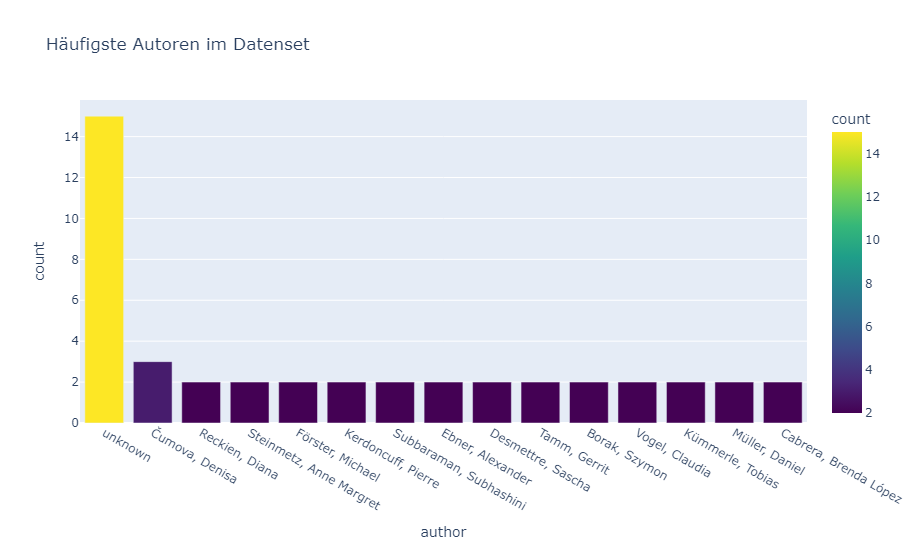

In [32]:
# Balkendiagramm erstellen
fig1 = px.bar(author_counts, x='author', y='count', height=550,
             title='Häufigste Autoren im Datenset', color='count', color_continuous_scale='Viridis')

# Diagramm anzeigen
fig1.show()

<a id="section4.2"></a>
### 6.2.  Darstellung der Publikationsjahre

Als weitere Anwendungsoption wird ein DataFrame aus den gegebenen Daten erstellt und nach der Prüfung der vorhandenen Spalten, das 'jahr' in numerische Werte konvertiert, um die Anzahl der Veröffentlichungen pro Jahr zu zählen. Für diese Zählung wird ein neues DataFrame erstellt, das die Jahre und die entsprechenden Anzahl der Veröffentlichungen enthält. Schließlich wird ein Liniendiagramm generiert, das die Entwicklung der Veröffentlichungen über die Jahre hinweg visualisiert, wobei die Jahre auf der x-Achse und die Anzahl der Veröffentlichungen auf der y-Achse dargestellt werden.

In [34]:
df_jahr = df[df['jahr'] != 'unknown'].copy()
df_jahr['jahr'] = pd.to_numeric(df['jahr'], errors='coerce')
#df_jahr

In [35]:
# Häufigkeit der Jahre zählen
jahr_counts = df['jahr'].value_counts().head(15).reset_index()
jahr_counts.columns=['jahr', 'count']
jahr_counts

,jahr,count
0,unknown,2035
1,2010,180
2,2009,161
3,2008,125
4,2007,73
5,2006,64
6,2003,53
7,2005,51
8,2004,37
9,2002,16


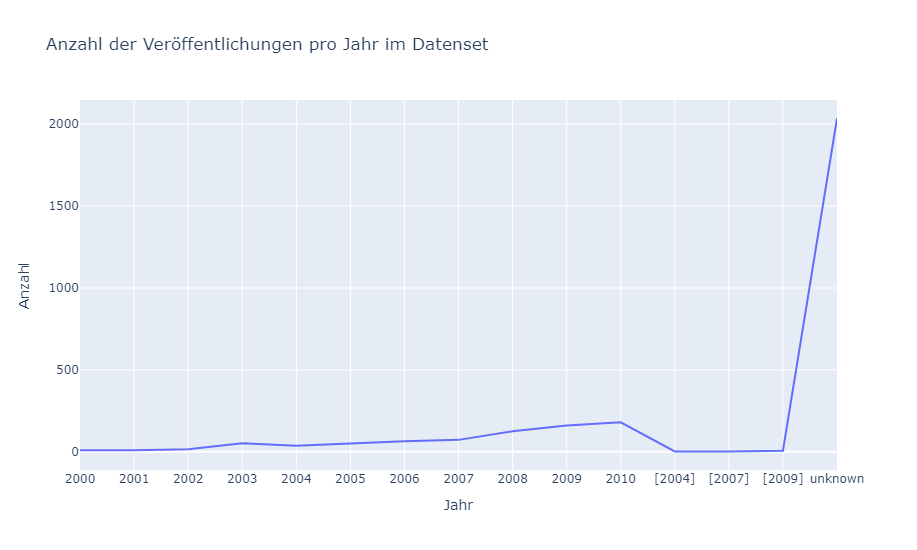

In [19]:
# Diagramm erstellen
fig2 = px.line(jahr_counts.sort_values('jahr'), x='jahr', y='count', height=550,
             title='Anzahl der Veröffentlichungen pro Jahr im Datenset',
             labels={'jahr': 'Jahr', 'count': 'Anzahl'})

# Diagramm anzeigen
fig2.show()

<a id="section4.3"></a>
### 6.3.  Darstellung der Publikationsjahre als Kreisdiagramm

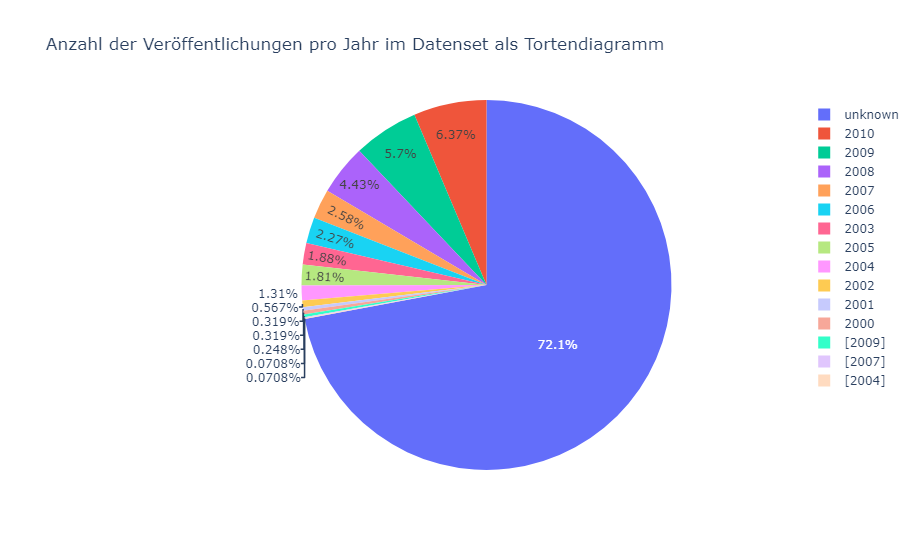

In [36]:
# Erstellen eines entsprechenden Kreisdiagramms: 
fig3 = px.pie(jahr_counts, names='jahr', values='count', height=550,
             title='Anzahl der Veröffentlichungen pro Jahr im Datenset als Tortendiagramm',
             labels={'jahr': 'Jahr', 'count': 'Anzahl'})

# Ändern der Beschriftung auf den einzelnen Tortenstücken: 
#fig3.update_traces(
    #textinfo='label+percent')#,  # Anzeigen des Jahres sowie des Prozentsatzes
    #insidetextorientation='horizontal' ) # Texausrichtung der Tortenstücke

# Anzeigen des Diagramms:
fig3.show()